In [54]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Baby example

In [55]:
def f(x):
    return 0.5*(x[0]**2+2*x[1]**2)

def grad_f(x):
    return np.array([x[0], 4*x[1]])

In [56]:
t = .05
x = [2*[1]]
loss = []
for i in range(0, 150):
    x.append( x[-1]-t*grad_f(x[-1]))
    loss.append(f(x[-1]))
print(np.round(x[-1], 5))

[0.00046 0.     ]


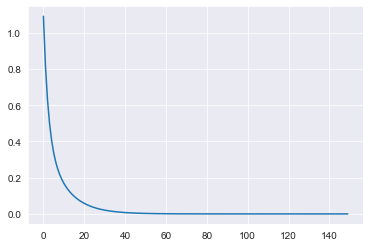

In [57]:
plt.figure()
plt.plot(loss)

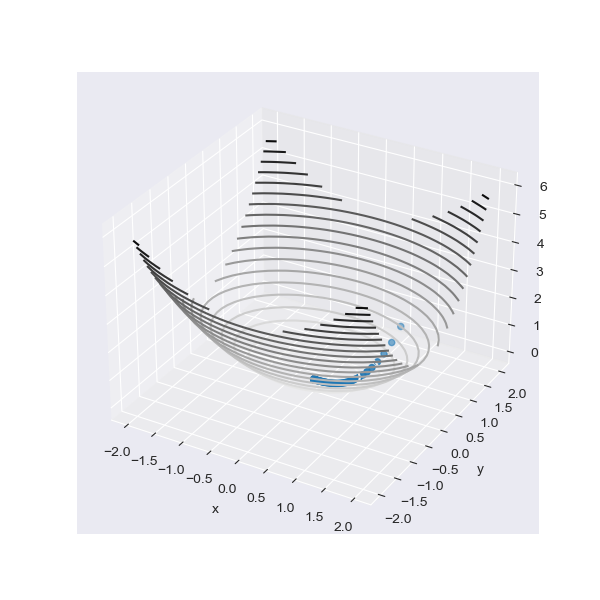

In [59]:
%matplotlib widget

x = np.array(x)
X, Y = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2, 2, 30))
Z = f([X, Y])
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 20, cmap='binary')
ax.scatter3D(x[:, 0 ], x[:, 1], f(x.T));
ax.set_xlabel('x')
ax.set_ylabel('y');

# OLS regression

In [60]:
class BaseLinearModel:
    
    def __init__(self, t=0.01, max_iter=100, fit_intercept=False, early_stop=False, tol=0.001):
        self.t = t
        self.max_iter = max_iter
        self.early_stop = early_stop
        self.iterates = np.arange(self.max_iter)
        self.beta = None
        self.intercept = None
        self.fit_intercept = fit_intercept
        self.tol = tol
        self.loss = None
        self.fitted = False
        
    @staticmethod
    def norm(vec):
        return np.linalg.norm(vec)
    
    def loss_func(self, beta, X, y):
        return 0.5*self.norm(y-X@beta)**2
    
    def step_size(self, X, y):
        return self.t 
    
    def gd_step(self, *args):
        X, y = args[:2]
        y_hat = X@self.beta+self.intercept
        if self.fit_intercept:
                self.intercept = self.intercept - self.step_size()*2*np.sum( y_hat-y)/len(X)
        return self.beta - self.step_size(X, y)*X.T@(y_hat-y)/len(X)
    
    def fit(self, X, y):
        self.beta = np.zeros(X.shape[1])
        self.intercept = 0
        loss = []
        for i in range(self.max_iter):
            self.beta = self.gd_step(X, y)
            loss.append(self.loss_func(self.beta, X, y))
            try:
                if self.early_stop and abs(loss[-1]-loss[-2])<self.tol:
                    print(f'stopping after {i} epochs')
                    break
            except IndexError:
                continue
        self.loss = np.array(loss)
        self.fitted = True
        return self
    
    def predict(self, X):
        if not self.fitted:
            print("Fit model first")
            return None
        return X@self.beta+self.intercept
    
    def score(self, X, y_true):
        y_pred = self.predict(X)
        res = self.norm(y_true-y_pred)**2
        tot = self.norm(y_true-np.mean(y_true))**2
        return 1-res/tot 

In [61]:
X = np.random.normal(0, 1, (1000, 10))
beta_true = np.zeros(X.shape[1])
beta_true[:3] = 5
y = X@beta_true+np.random.normal(0, 1, 1000)

stopping after 724 epochs
R^2= 0.986


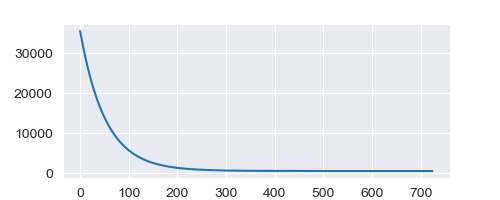

In [62]:
BaseLM = BaseLinearModel(.01, 1000, early_stop=True)
BaseLM.fit(X, y)
print(f"R^2={ BaseLM.score(X,y): .3f}")
plt.figure(figsize=(5,2))
plt.plot(BaseLM.loss);

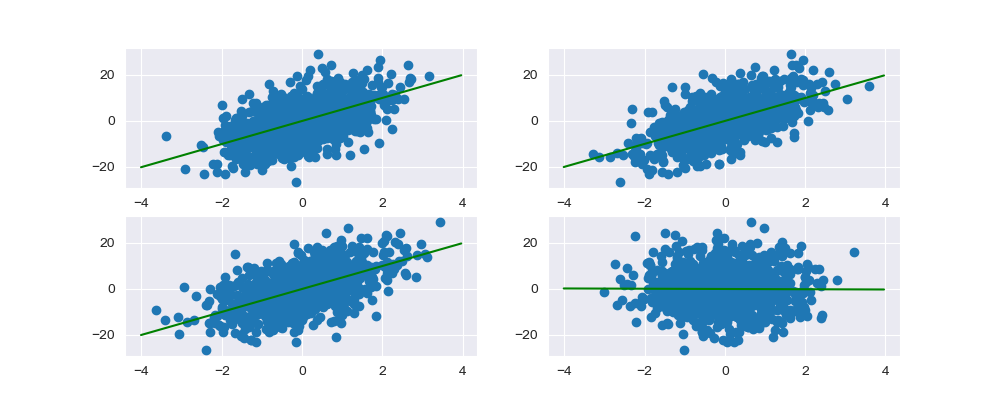

In [63]:
x = np.linspace(X.min(), X.max(), 100)
fig, axs = plt.subplots(2, 2, figsize=(10,4))
axs[0,0].plot(x, x*BaseLM.beta[0], color='green')
axs[0,0].scatter(X[:, 0], y)
axs[0,1].plot(x, x*BaseLM.beta[1], color='green')
axs[0,1].scatter(X[:, 1], y)
axs[1,0].plot(x, x*BaseLM.beta[2], color='green')
axs[1,0].scatter(X[:, 2], y)
axs[1,1].plot(x, x*BaseLM.beta[3], color='green')
axs[1,1].scatter(X[:, 3], y)

In [64]:
exec_time = []
for _ in range(1000):
    t0 = time()
    BaseLM.gd_step(X, y)
    exec_time.append(time()-t0)
print(f"Mean per iteration execution time: {10**6*np.mean(exec_time):.3f}us")

Mean per iteration execution time: 14.998us


# Armijo line-search

In [65]:
class LinearModel(BaseLinearModel):
    def __init__(self, t, max_iter=1000, fit_intercept=False, eta=0.8, k=.5, backtrack=True, early_stop=False, tol=0.001):
        super().__init__(t, max_iter, fit_intercept, early_stop, tol)
        self.eta = eta
        self.k = k
        self.backtrack = backtrack
        
    def step_size(self, X, y):
        if not self.backtrack:
            return self.t
        grad = X.T@(X@self.beta-y)
        f = lambda beta_: self.loss_func(beta_, X, y)
        while f(self.beta-self.t*grad)<f(self.beta)+self.t*self.k*grad.T@grad:
            self.t *= self.eta
        return self.t

stopping after 5 epochs
R^2=0.986


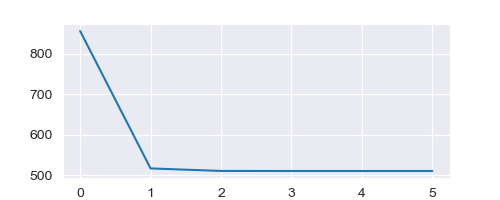

In [66]:
LM = LinearModel(1, 50, backtrack=True, early_stop=True)
LM.fit(X, y)
print(f"R^2={LM.score(X,y):.3f}")
plt.figure(figsize=(5,2))
plt.plot(LM.loss)

In [67]:
exec_time = []
for _ in range(1000):
    t0 = time()
    LM.gd_step(X, y)
    exec_time.append(time()-t0)
print(f"Mean per iteration execution time: {10**6*np.mean(exec_time):.3f}us")

Mean per iteration execution time: 44.997us


In [68]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
print(f"R^2={ reg.score(X,y): .3f}")

R^2= 0.986


# Fractional GD

$$
\partial^s_a f = \frac{1}{\Gamma(1-s)}\int_{a=-\varepsilon}^x\frac{\partial f(\tau)}{(x-\tau)^s}
$$

$$
x \leftarrow x-t\partial^sf(x)
$$

In [69]:
import scipy as sc
from scipy import integrate

def caputo(x, s, grad_func, a=0., lam=0.2):
    # if not np.prod(grad_func(x)):
    #     return 0
    def integrand(tau):
        return (1/sc.special.gamma(1-s))*(grad_func(tau))/(x-tau)**(s)
    return integrate.quad(np.vectorize(integrand), a, x)[0]

def caputo(x, s, grad_func, a=0., lam=0.2):
    # if not np.prod(grad_func(x)):
    #     return 0
    def integrand(tau):
        return (1/sc.special.gamma(1-s))*(grad_func(tau))*np.exp(-s*(x-tau)/(1-s))
    return integrate.quad(np.vectorize(integrand), a, x)[0]




caputo = np.vectorize(caputo)

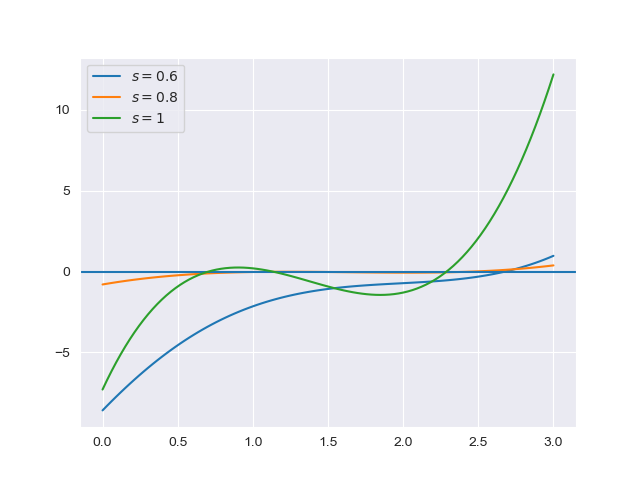

In [70]:
f = lambda x:  x**4-5.5*x**3+10*x**2-7.3*x
df = lambda x: 4*x**3-5.5*3*x**2+20*x-7.3
x = np.linspace(0, 3, 100)

plt.figure()
for gamma in [0.6, 0.8]:
    plt.plot(x, caputo(x, gamma, df, a=-2), label=fr"$s={gamma}$")
plt.axhline(0)
plt.plot(x,df(x), label=r'$s=1$')
plt.legend();

In [71]:
def df_caputo(x, s, a):
    return np.array([caputo(x[0], s, df, a), 
                     caputo(x[1], s, df, a)])

In [76]:
t = .02
ff = lambda x:  x[0]**4-5.5*x[0]**3+10*x[0]**2-7.3*x[0]+ x[1]**4-5.5*x[1]**3+10*x[1]**2-7.3*x[1]

x = [np.array([0, 0.2])]
loss = []
for i in range(0, 450):
    grad = df_caputo(x[-1], 0.5*np.random.rand(), -np.random.rand()*0.01)
    x.append( x[-1]-t*grad)
    loss.append(np.linalg.norm(grad))
print(np.round(x[-1], 5))

[2.84115 2.84115]


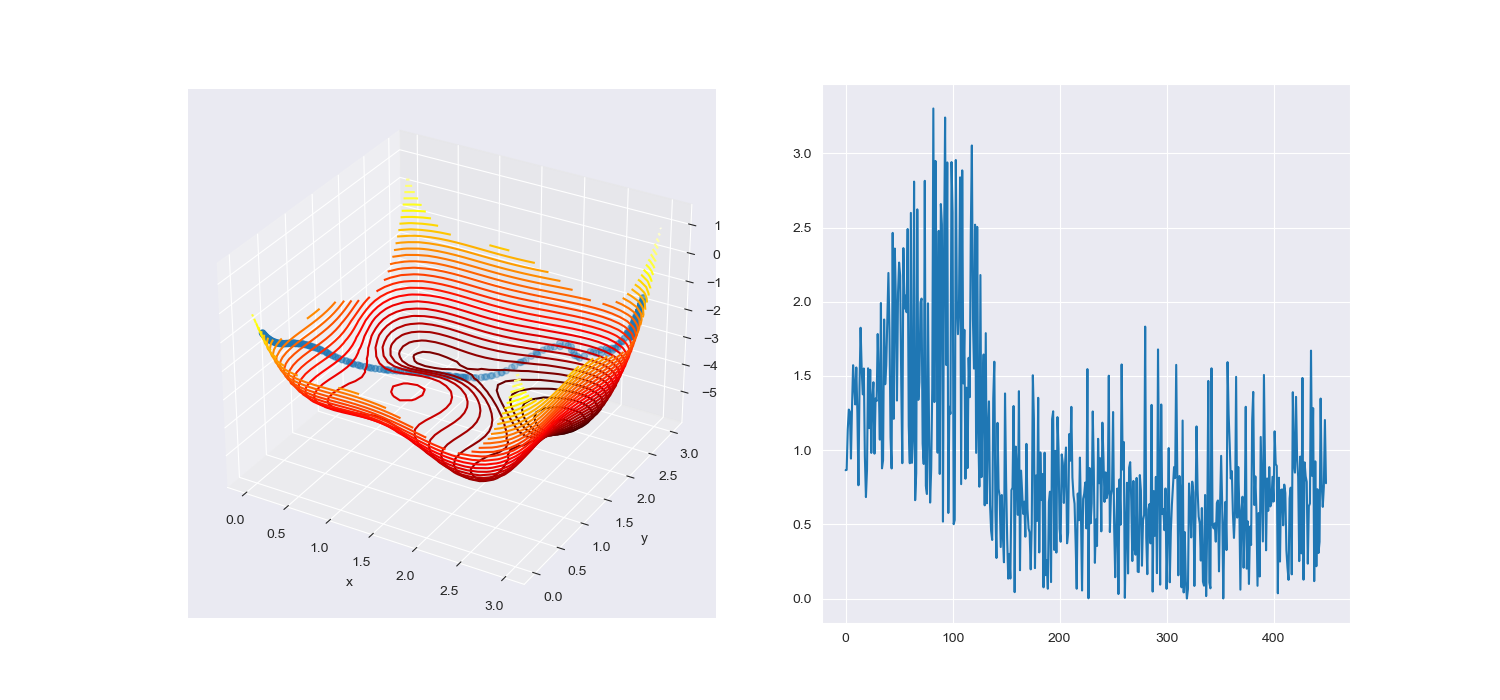

In [77]:
x = np.array(x)
X, Y = np.meshgrid(np.linspace(0, 3, 30), np.linspace(0, 3, 30))
Z = ff([X, Y])
fig= plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.contour3D(X, Y, Z, 40, cmap='hot')
ax1.scatter3D(x[:, 0 ], x[:, 1], ff(x.T));
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(loss)

In [47]:
x_ = np.linspace(0, 6, 5000)
df_ = df(x_)
x_[np.abs(df_)<0.001]

array([0.70454091, 1.13182637, 2.28885777])

### Execution time of fractional grad step

In [22]:
per_iter_time = []
for _ in range(0, 1000):
    start = time()
    df_caputo(x[-1], 0.5, -0.01)
    per_iter_time.append(time()-start)
print('fractional gradient average time: ',np.mean(per_iter_time))
per_iter_time = []
for _ in range(0, 1000):
    start = time()
    df(x[-1])
    per_iter_time.append(time()-start)
print('gradient average time: ',np.mean(per_iter_time))

fractional gradient average time:  0.001132002592086792
gradient average time:  4.9967765808105465e-06
